# Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from env import get_connection

import acquire, prepare

pd.options.display.max_columns = None

In [2]:
# 20% test, 80% train_validate
# then of the 80% train_validate: 30% validate, 70% train. 
def train_validate(df, stratify_col = None):
    """
    This function takes in a DataFrame and column name for the stratify argument (defualt is None).
    It will split the data into three parts for training, testing and validating.
    """
    #This is logic to set the stratify argument:
    stratify_arg = ''
    if stratify_col != None:
        stratify_arg = df[stratify_col]
    else:
        stratify_arg = None
    
    #This splits the DataFrame into 'train' and 'test':
    train, test = train_test_split(df, train_size=.7, stratify=stratify_arg, random_state = 321)
    
    #The length of the stratify column changed and needs to be adjusted:
    if stratify_col != None:
        stratify_arg = train[stratify_col]
        
    #This splits the larger 'train' DataFrame into a smaller 'train' and 'validate' DataFrames:
    train, validate = train_test_split(train, test_size=.5, stratify=stratify_arg, random_state = 321)
    return train, validate, test

# Part 1: Titanic

In [3]:
#Acquire and prepare data for processing:
titanic = acquire.get_titanic_data()
titanic = prepare.prep_titanic(titanic)

In [4]:
#Splits data into three sets for testing. Stratifies on target column 'survived'.
ti_train, ti_val, ti_test = train_validate(titanic, 'survived')

In [5]:
#Establish baseline using the majority option of target column.
ti_train.survived.value_counts()

0    192
1    119
Name: survived, dtype: int64

### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [6]:
#Builds a DataFrame the same size as the train data set with the baseline of 0 or 'did not survive.'
ti_base = pd.DataFrame()
ti_base['baseline_prediction'] = ti_train['survived']
ti_base['baseline_prediction'] = ti_base['baseline_prediction'] * 0

In [7]:
# In the telco example, the accuracy_score does not like 'int' type inputs. 
# For some reason it works here and all input as similar in type...

In [8]:
#Used to evaluate inputs to the accuracy_score function:
#print(ti_base.info())
#print(ti_train.survived.info())
#print(ti_base.value_counts())
#print(ti_train.survived.value_counts())

In [9]:
ti_baseline = accuracy_score(ti_train.survived, ti_base.baseline_prediction)
print(f'The baseline is: {ti_baseline:.3f}')

The baseline is: 0.617


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [10]:
#Creates the various sets and drops the target column from the X set:
X_train = ti_train.drop(columns=['survived'])
y_train = ti_train['survived']

X_val = ti_val.drop(columns=['survived'])
y_val = ti_val['survived']

X_test = ti_test.drop(columns=['survived'])
y_test = ti_test['survived']

In [11]:
seed = 42

clf = DecisionTreeClassifier(max_depth=3, random_state=42)

In [12]:
# This is for an error where clf is trying to concat a string to an int.
# It did not occure in my code and I'm unsure why.

#class_names = np.array(clf.classes_).astype('str').tolist()

In [13]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [14]:
#Model score:
clf.score(X_train, y_train)

0.8167202572347267

In [15]:
#Confusion matrix:

#Makes prediction on train obeservations
y_pred = clf.predict(X_train)

pd.DataFrame(confusion_matrix(y_train, y_pred), index=['Pred_live', 'Pred_death'], columns=['Act_live','Act_death'])

,Act_live,Act_death
Pred_live,173,19
Pred_death,38,81


In [16]:
#This is plotting the confusion matrix but I'm unsure how to get it to work at this time:

#Website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

#plot_confusion_matrix(clf, X_train, y_train)

In [17]:
#Classification report:
print(classification_report(y_train, y_pred),)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       192
           1       0.81      0.68      0.74       119

    accuracy                           0.82       311
   macro avg       0.81      0.79      0.80       311
weighted avg       0.82      0.82      0.81       311



### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [18]:
#This seems repetitive so I incorperated the validate data set:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       192
           1       0.81      0.68      0.74       119

    accuracy                           0.82       311
   macro avg       0.81      0.79      0.80       311
weighted avg       0.82      0.82      0.81       311



In [19]:
#Prediction based on validate data:
y_val_pred = clf.predict(X_val)
pd.DataFrame(confusion_matrix(y_val, y_val_pred), index=['Pred_live', 'Pred_death'], columns=['Act_live','Act_death'])

,Act_live,Act_death
Pred_live,174,18
Pred_death,44,76


In [20]:
#Comparison of the model on the training and validate data sets:
#Training data set
accuracy_score(y_train, y_pred)

0.8167202572347267

In [21]:
#Validate data set
accuracy_score(y_val, y_val_pred)

0.8012820512820513

In [22]:
#Interesting way to snag values from confusion_matrix:
TN, FP, FN, TP = confusion_matrix(y_train, y_pred).ravel()
TN, FP, FN, TP

(173, 19, 38, 81)

In [23]:
for i in range(1, 21):
    trees = DecisionTreeClassifier(max_depth=i, random_state=42)
    trees = trees.fit(X_train, y_train)
    y_preds = trees.predict(X_train)
    report = classification_report(y_train, y_preds, output_dict=True) #output_dict makes the output a dictionary.
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                    0           1  accuracy   macro avg  weighted avg
precision    0.811881    0.743119  0.787781    0.777500      0.785570
recall       0.854167    0.680672  0.787781    0.767419      0.787781
f1-score     0.832487    0.710526  0.787781    0.771507      0.785821
support    192.000000  119.000000  0.787781  311.000000    311.000000

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.769231    0.968750  0.810289    0.868990      0.845574
recall       0.989583    0.521008  0.810289    0.755296      0.810289
f1-score     0.865604    0.677596  0.810289    0.771600      0.793665
support    192.000000  119.000000  0.810289  311.000000    311.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.819905    0.810000   0.81672    0.814953      0.816115
recall       0.901042    0.680672   0.81672    0.790857      0.816720
f1-score     

In [24]:
metrics = []

for i in range(1, 25):
    trees = DecisionTreeClassifier(max_depth=i, random_state=42)
    trees = trees.fit(X_train, y_train)
    in_sample_accuracy = trees.score(X_train, y_train)
    out_of_sample_accuracy = trees.score(X_val, y_val)

    output = {"max_depth" : i, "train_accuracy": in_sample_accuracy, "validate_accuracy": out_of_sample_accuracy}
              
    metrics.append(output)

df = pd.DataFrame(metrics)              
df['difference'] = df.train_accuracy - df.validate_accuracy              
df              


,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.787781,0.778846,0.008935
1,2,0.810289,0.778846,0.031443
2,3,0.816720,0.801282,0.015438
3,4,0.848875,0.775641,0.073234
4,5,0.858521,0.791667,0.066854
5,6,0.884244,0.788462,0.095783
6,7,0.909968,0.782051,0.127917
7,8,0.929260,0.791667,0.137594
8,9,0.932476,0.791667,0.140809
9,10,0.938907,0.794872,0.144035


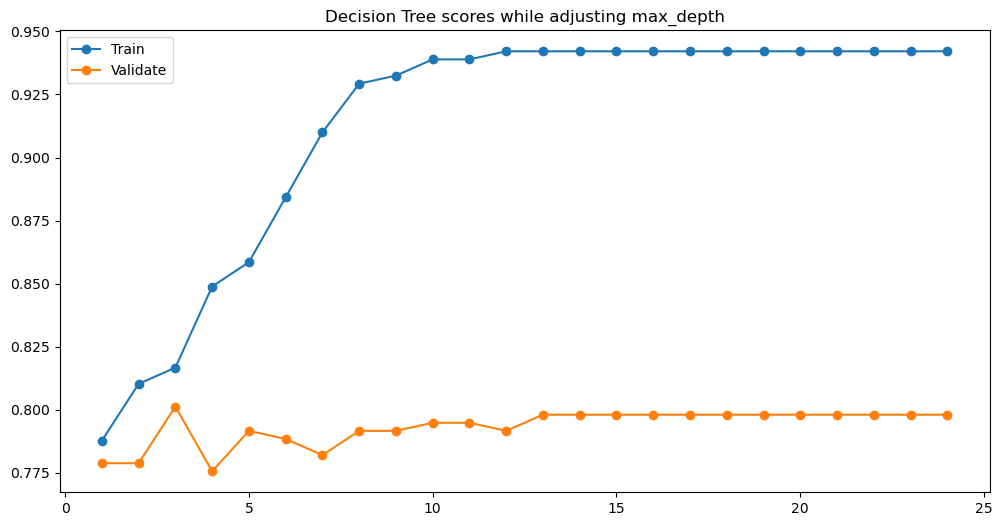

In [25]:

plt.figure(figsize=(12,6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label= 'Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label= 'Validate')
plt.legend()
plt.title("Decision Tree scores while adjusting max_depth")
plt.show()


### 5. Run through steps 2-4 using a different max_depth value.

In [26]:
seed = 42
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

In [27]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [28]:
clf.score(X_train, y_train)

0.8585209003215434

In [29]:
y_pred = clf.predict(X_train)

In [30]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=['Pred_live', 'Pred_death'], columns=['Act_live','Act_death'])

,Act_live,Act_death
Pred_live,177,15
Pred_death,29,90


In [31]:
print(
    classification_report(y_train, y_pred),)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       192
           1       0.86      0.76      0.80       119

    accuracy                           0.86       311
   macro avg       0.86      0.84      0.85       311
weighted avg       0.86      0.86      0.86       311



In [32]:
y_val_pred = clf.predict(X_val)

pd.DataFrame(confusion_matrix(y_val, y_val_pred), index=['Pred_live', 'Pred_death'], columns=['Act_live','Act_death'])

,Act_live,Act_death
Pred_live,178,14
Pred_death,51,69


In [33]:
accuracy_score(y_val, y_val_pred)

0.7916666666666666

### 6. Which model performs better on your in-sample data?

The depth 5 model performs better on the training data. Step 5.

### 7. Which model performs best on your out-of-sample data, the validate set?

The depth 3 model performs better on the training data. Steps <=4.

# Part 2: Telco churn

## 1. Work through these same exercises using the Telco dataset.

In [34]:
telco = acquire.get_telco_data()

In [35]:
init_info = telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [36]:
telco = prepare.prep_telco(telco)

In [37]:
processed_info = telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   senior_citizen                         7043 non-null   int64  
 1   partner                                7043 non-null   int64  
 2   dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   paperless_billing                      7043 non-null   int64  
 5   monthly_charges                        7043 non-null   float64
 6   total_charges                          7043 non-null   float64
 7   churn                                  7043 non-null   int64  
 8   gender_Male                            7043 non-null   uint8  
 9   streaming_movies_No internet service   7043 non-null   uint8  
 10  streaming_movies_Yes                   7043 non-null   uint8  
 11  stre

You have to drop sting columns:

In [38]:
tel_train, tel_val, tel_test = train_validate(telco, 'churn')

### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [39]:
tel_train.churn.value_counts()

0    1811
1     654
Name: churn, dtype: int64

In [40]:
#The accuracy_score does not like int input but it seems to work.
#tel_base = tel_base.astype('string')
#tel_train.churn = tel_train.churn.astype('string')

tel_baseline = accuracy_score(tel_train.churn, (tel_train.churn * 0))
print(f'The baseline is: {tel_baseline:.3f}')

The baseline is: 0.735


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [41]:
#tel_train.churn = tel_train.churn.astype('int')

In [42]:
X_train = tel_train.drop(columns=['churn'])
y_train = tel_train['churn']

X_val = tel_val.drop(columns=['churn'])
y_val = tel_val['churn']

X_test = tel_test.drop(columns=['churn'])
y_test = tel_test['churn']

In [43]:
seed = 42

clf = DecisionTreeClassifier(max_depth=3, random_state=42)

In [44]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [45]:
y_pred = clf.predict(X_train)

In [46]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=['Pred Churn', 'Pred Stay'], columns=['Act Churn','Act Stay'])

,Act Churn,Act Stay
Pred Churn,1703,108
Pred Stay,404,250


### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [47]:
class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True, target_names = ['Churn', 'Not Churn']))
class_report

,Churn,Not Churn,accuracy,macro avg,weighted avg
precision,0.808258,0.698324,0.792292,0.753291,0.779091
recall,0.940364,0.382263,0.792292,0.661314,0.792292
f1-score,0.869321,0.494071,0.792292,0.681696,0.769762
support,1811.000000,654.000000,0.792292,2465.000000,2465.000000


### 5. Run through steps 2-4 using a different max_depth value.

In [48]:
metrics = []

for i in range(1,20):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)
    in_sample_accuracy = clf.score(X_train, y_train)
    out_of_sample_accuracy = clf.score(X_val, y_val)
    
    output = {"max_depth": i, "train_accuracy": in_sample_accuracy, "validate_accuracy": out_of_sample_accuracy}
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df['difference'] = df.train_accuracy - df.validate_accuracy

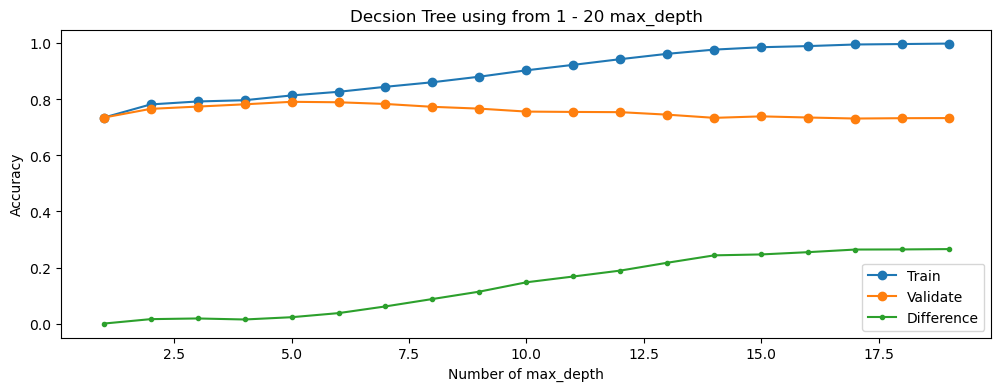

In [49]:

plt.figure(figsize=(12,4))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o', label= 'Train')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o', label= 'Validate')
plt.plot(df.max_depth, df.difference, marker = '.', label = 'Difference')
plt.legend()
plt.title("Decsion Tree using from 1 - 20 max_depth")
plt.xlabel("Number of max_depth")
plt.ylabel("Accuracy")
plt.show()


### 6. Which model performs better on your in-sample data?

As the max_depth increases, the accuracy increases.

### 7. Which model performs best on your out-of-sample data, the validate set?

From 2-5 max_depth, the validation set seems to perform the best.

## 2. Experiment with this model on other datasets with a higher number of output classes.